# MDI230 : Queueing theory

## Simulation Velib

#### Rémi Jaylet, Augustin Laboulet, Romain Louvet

### Imports

In [8]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import seaborn as sns

# Simulation

## Question 3

### Definition des paramètres

In [9]:
# Nombre de stations
S = 5

# Nombre de vélos
N = 1

# Matrice de routage
P = np.array([[0, 0.22, 0.32, 0.2, 0.26],
              [0.17, 0, 0.34, 0.21, 0.28], 
              [0.19, 0.26, 0, 0.24, 0.31], 
              [0.17, 0.22, 0.33, 0, 0.28], 
              [0.18, 0.24, 0.35, 0.23, 0]])

# Temps moyen de trajet
Tau = np.array([[0, 3, 5, 7, 7],
                [2, 0, 2, 5, 5], 
                [4, 2, 0, 3, 3], 
                [8, 6, 4, 0, 2], 
                [7, 7, 5, 2, 0]]) *60

# Taux de départ par seconde 
Lambda = np.array([2.8, 3.7, 5.5, 3.5, 4.6])/3600

#Matrice des conditions initiales
N_station_CI = np.array([20, 15, 17, 13, 18])

N_trajet_CI = np.array([[0, 1, 0, 0, 0],
                        [1, 0, 1, 0, 0], 
                        [0, 1, 0, 1, 0], 
                        [0, 0, 1, 0, 1], 
                        [0, 0, 0, 1, 0]])

CI = N_trajet_CI + np.diag(N_station_CI)

In [10]:
def lambda_itij(i, j):
    return Lambda[i] * P[i, j]
    
def lambda_tijj(i, j):
    if (i==j):
        return 0
    else :
        return 1 / Tau[i, j]

### Simulation de la trajectoire

In [11]:
def pick_state(n, somme_lambda):
    
    tirage = rd.uniform()
    prog_lambda = 0
    
    for k in range(2):
        for j in range(5):
            for i in range(5):
                if i != j :
                    prog_lambda += (lambda_itij(i, j) * (n[i, i] > 0)) if k == 0 else (lambda_tijj(i, j) * n[i, j])
                    if prog_lambda / somme_lambda > tirage:
                        return (i, i, i, j) if k == 0 else (i, j, j, j)

In [12]:
def velib(seuil):
    
    # initilisation
    etats = CI
    s1, s2, s3, s4, s5 = [N_station_CI[0]], [N_station_CI[1]], [N_station_CI[2]], [N_station_CI[3]], [N_station_CI[4]]
    time = [0]
    somme_tau = 0
    
    while somme_tau < seuil :
        somme_lambda = 0

        for i in range (5):
            for j in range(5):
                if i != j:
                    somme_lambda += lambda_itij(i, j) * (etats[i, i] > 0) + lambda_tijj(i, j) * etats[i, j]
        
        S = rd.exponential(1 / somme_lambda)
        somme_tau += S            

        # operateur de transfert
        (i_down, j_down, i_up, j_up) = pick_state(etats, somme_lambda)
        etats[i_down][j_down] -= 1
        etats[i_up][j_up] += 1
        
        # met à jour variables
        N_station = np.diag(etats)
        time.append(time[-1] + S)
        s1.append(N_station[0])
        s2.append(N_station[1])
        s3.append(N_station[2])
        s4.append(N_station[3])
        s5.append(N_station[4])

    return time, s1, s2, s3, s4, s5, etats

### Resultats

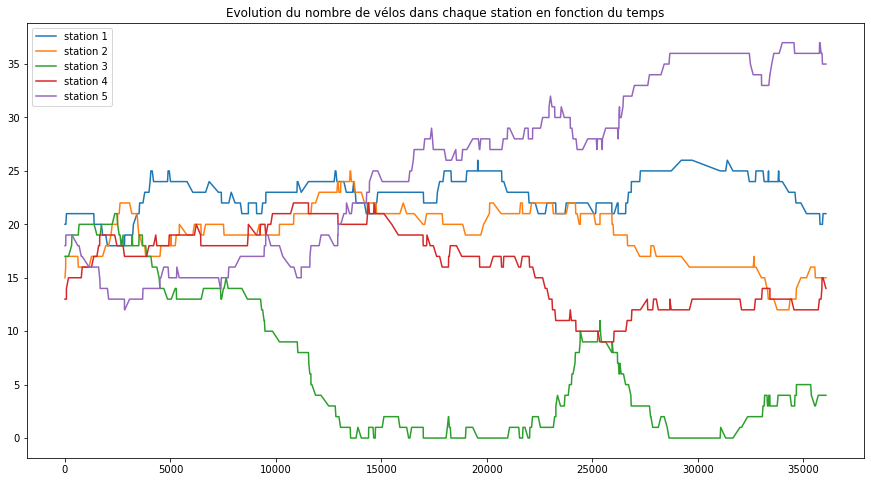

In [13]:
res = velib(36000)

time = res[0]

s1, s2, s3, s4, s5 = res[1], res[2], res[3], res[4], res[5]

plt.figure(figsize = (15,8))
plt.plot(time, s1, label = "station 1")
plt.plot(time, s2, label = "station 2")
plt.plot(time, s3, label = "station 3")
plt.plot(time, s4, label = "station 4")
plt.plot(time, s5, label = "station 5")
plt.legend()
plt.title("Evolution du nombre de vélos dans chaque station en fonction du temps")

plt.show()

## Question 4

In [28]:
#initialization
N = 100
s_vides = [0,0,0,0,0]

for i in range(N):
    etats = velib(540000)[-1]
    for j in range(5):
        if etats[j, j] == 0:
            s_vides[j] += 1

p_s_vides = np.array(s_vides)/N

print("Les probabilités que les stations soient vides après 150 heures sont : \n", 
      dict(zip(['s1', 's2', 's3', 's4', 's5'], p_s_vides)))

Les probabilités que les stations soient vides après 150 heures sont : 
 {'s1': 0.0, 's2': 0.06, 's3': 0.17, 's4': 0.05, 's5': 0.08}


## Question 5

In [33]:
ecart_type = [ np.sqrt(N/(N-1)*(p_s_vides[k]-p_s_vides[k]**2)) for k in range(len(s_vides)) ]
epsilon = [ 1.96*ecart_type[k]/np.sqrt(N) for k in range(len(s_vides)) ]

IC_vides = [ [round(p_s_vides[k]-epsilon[k],3), round(p_s_vides[k]+epsilon[k],3)] for k in range(len(s_vides)) ]

print("Les intervalles de confiance sont :", 
      dict(zip(['s1', 's2', 's3', 's4', 's5'], IC_vides)))

Les intervalles de confiance sont : {'s1': [0.0, 0.0], 's2': [0.013, 0.107], 's3': [0.096, 0.244], 's4': [0.007, 0.093], 's5': [0.027, 0.133]}


# Calcul théorique

## Question 6

On peut utiliser les équations de trafic ci-dessous pour obtenir les relations entre les αi :

$$\left \{ \begin{array}{l} \sum_{j = 1}^J \alpha_j = 1 \\
\forall j \leq J, \alpha_j \sum_{k = 1}^J \lambda_{jk} = \sum_{k = 1}^J \alpha_k \lambda_{kj} \end{array} \right .$$

On ne considère que : 
- que les transitions d'une station à une autre. On peut ainsi réécrire les équations du trafic
- 5 stations

$$\left \{ \begin{array}{l} \sum _{i = 1}^5 \sum_{j = 1}^5 \alpha_{t_{ij}} = 1 \\
\forall i \leq 5, \left \{ \begin{array}{l} \alpha_i \sum_{j = 1, \neq i}^5 \lambda_{i, t_{ij}} = \sum_{j = 1, \neq i}^5 \alpha_{t_{ji}} \lambda_{t_{ji}, i} (1) \\
\forall j \neq i, \alpha_{t_{ij}} \lambda_{t_{ij}, j} = \alpha_i \lambda_{i, t_{ij}} (2) \end{array} \right. \end{array} \right .$$

Sachant que $\alpha_i \equiv \alpha_{t_{ii}}, \lambda_i \equiv \lambda_{t_{ii}}$) :


Or, d'après $(2)$,  $ \Rightarrow \forall j \neq i, \alpha_{t_{ij}} = \alpha_i \frac{\lambda_{i, t_{ij}}}{\lambda_{t_{ij}, j}}$

On utilise cette relation sur le côté droit de l'équation dans $(1)$:

$$ \forall i \leq 5, \alpha_i \sum_{j = 1, \neq i}^5 \lambda_{i, t_{ij}} = \sum_{j = 1, \neq i}^5 \alpha_j \lambda_{j, t_{ji}} \\
\Leftrightarrow \forall i \leq 5, \alpha_i \sum_{j = 1, \neq i}^5 \lambda_{i, t_{ij}} - \sum_{j = 1, \neq i}^5 \alpha_j \lambda_{j, t_{ji}} = 0 \\
\Leftrightarrow M\alpha = X$$

Avec : 
$$\alpha = \begin{pmatrix} \alpha_1 \\ ... \\ \alpha_5 \end{pmatrix} \\
M_{ij} = \left \{ \begin{array}{l} \sum_{k = 1, \neq i}^5 \lambda_{i, t_{ik}} \textrm{ si } i = j \\
 - \lambda_{j, t_{ji}} \textrm{ sinon } \end{array} \right .\\
X = 0$$

On remplace la dernière ligne de $M$ par une ligne de 1, et on remplace la dernière valeur de $X$ par un 1 pour ne pas avoir une solution nulle. Cette équation permet d'obtenir les $\alpha_i$ comme solution de $\alpha = M^{-1}X$. $(2)$ permet de déduire les $\alpha_{t_{i, j}}$.$.


## Question 7

On considère maintenant que le système contient un unique vélo. Cela signifie que l'espace des états se résume à un état par colonie, soit  𝑆2  si  𝑆  est le nombre de stations. Pour nous,  $𝑆 = 5$  donc on a  $ 𝐽 = 25 $  états.

## Question 8

On utilise la définition ci-dessus des $\alpha_j$ pour exprimer la distribution d'équilibre du problème :

$$\pi(n) = G_N^{-1} \prod^J_{j=1} \frac{\alpha_j^{n_j}}{\prod^{n_j}_{r=1} \phi_j(r)}$$

Les valeurs possibles de $n$ sont les $e_i$ (es vecteurs de la base canonique) de $\mathbb R^J$ avec $(e_i)_j  = \delta_{ij}$. 

Ainsi :

$$\mathbb P(n_k = 0) = 1 - \mathbb P(n_k = 1) = 1 - \pi(e_k) \\
= 1 - G_N^{-1} \prod^J_{j=1} \frac{\alpha_j^{\delta_{jk}}}{\prod^{\delta_{jk}}_{r=1} \phi_j(r)} \\
= 1 - G_N^{-1} \frac{\alpha_k}{\phi_k(1)} \\
= 1 - G_N^{-1} \alpha_k$$

On peut de plus calculer le terme de normalisation puisque notre unique vélo ne peut pas être dans deux colonies à la fois ni dans aucune :

$$\sum_{k = 1}^J \mathbb P(n_k = 1) = 1 \\
= \sum_{k = 1}^J G_N^{-1}  \alpha_k \\
\Leftrightarrow G_N = \sum_{k = 1}^J \alpha_k$$

## Question 9
Comparez aux résultats obtenus par simulation. --Q14

In [ ]:
## Nouvelles CI 
N_station_CI = np.array([1, 1, 0, 0, 0])
N_trajet_CI = np.zeros((5, 5))
CI = N_trajet_CI + np.diag(N_station_CI)

#initialization
N = 100
s_vides = [0,0,0,0,0]

for i in range(N):
    etats = velib(540000)[-1]
    for j in range(5):
        if etats[j, j] == 0:
            s_vides[j] += 1

p_s_vides = np.array(s_vides)/N

print("Les probabilités que les stations soient vides après 150 heures sont : \n", 
      dict(zip(['s1', 's2', 's3', 's4', 's5'], p_s_vides)))


# Simulation pour 100 vélos

## Question 10
Simuler le même réseau avec 100 vélos, initialement répartis de façon
uniforme entre les stations et les routes.

## Question 11
Calculer la probabilité stationnaire que chaque station soit vide par
la méthode décrite en section 7.4. On n’oubliera pas de préciser
l’intervalle de confiance.